In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himanshu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tweets_data = pd.read_csv('vaccination_all_tweets.csv')
tweets_data.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False


In [3]:
tweets_data = tweets_data.drop(['user_name', 'user_location', 
                                'user_description', 'user_created', 
                                'user_followers', 'user_friends', 
                                'user_favourites', 'user_verified', 
                                'source', 'retweets', 'favorites', 'is_retweet'], axis=1)

tweets_data['date'] = pd.to_datetime(tweets_data['date']).dt.date
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197870 entries, 0 to 197869
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        197870 non-null  int64 
 1   date      197870 non-null  object
 2   text      197870 non-null  object
 3   hashtags  154883 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [4]:
# fill null with 'Notags'
tweets_data['hashtags'] = tweets_data['hashtags'].fillna('Notags')
# cleaning and adaptive for analysis
tweets_data['hashtags'] = [re.sub("[(\[\')|(\]\')|\s]", '', tags) for tags in tweets_data['hashtags']]
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197870 entries, 0 to 197869
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        197870 non-null  int64 
 1   date      197870 non-null  object
 2   text      197870 non-null  object
 3   hashtags  197870 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [5]:
tweets_data.head()


,id,date,text,hashtags
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cyt...,PfizerBioNTech
1,1338158543359250433,2020-12-13,While the world has been on the wrong side of ...,Notags
2,1337858199140118533,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"coronavirus,SputnikV,AstraZeneca,PfizerBioNTec..."
3,1337855739918835717,2020-12-12,"Facts are immutable, Senator, even when you're...",Notags
4,1337854064604966912,2020-12-12,Explain to me again why we need a vaccine @Bor...,"whereareallthesickpeople,PfizerBioNTech"


In [6]:
# prepare stopwords
stopwords = set(stopwords.words('english'))

# this 'deEmojify': via https://www.kaggle.com/sharibkhan/my-first-semantic-analysis-problem-in-nlp
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def nlp(text):
    corpus = []
    text = deEmojify(text)
    text = re.sub('http\S+', '', text) # remove url
    text = re.sub('#\w+', '', text) # remove hashtags
    text = re.sub('@[^\s]+', '', text) # remove @twitter_id
    text = text.split()
    corpus = [txt for txt in text if not txt in stopwords]
    return ' '.join(corpus)

tweets_data['text_nlp'] = tweets_data['text'].apply(lambda x: nlp(x))
tweets_data['text_nlp'].head()

0    Same folks said daikon paste could treat cytok...
1    While world wrong side history year, hopefully...
2               Russian vaccine created last 2-4 years
3    Facts immutable, Senator, even ethically sturd...
4                                 Explain need vaccine
Name: text_nlp, dtype: object

In [7]:
tweets_data

,id,date,text,hashtags,text_nlp
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cyt...,PfizerBioNTech,Same folks said daikon paste could treat cytok...
1,1338158543359250433,2020-12-13,While the world has been on the wrong side of ...,Notags,"While world wrong side history year, hopefully..."
2,1337858199140118533,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"coronavirus,SputnikV,AstraZeneca,PfizerBioNTec...",Russian vaccine created last 2-4 years
3,1337855739918835717,2020-12-12,"Facts are immutable, Senator, even when you're...",Notags,"Facts immutable, Senator, even ethically sturd..."
4,1337854064604966912,2020-12-12,Explain to me again why we need a vaccine @Bor...,"whereareallthesickpeople,PfizerBioNTech",Explain need vaccine
...,...,...,...,...,...
197865,1440564081690222607,2021-09-22,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,"URBAN,Bengaluru,CovidVaccine,COVISHIELD",18-44 Availability 22/09 12:00PM FREE Slots 0 ...
197866,1440558888898621442,2021-09-22,Pincode: 560066\nSPUTNIK V - Dose 1: 25 slots\...,Notags,Pincode: 560066 SPUTNIK V - Dose 1: 25 slots A...
197867,1440556528474345492,2021-09-22,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,"URBAN,Bengaluru,CovidVaccine,COVISHIELD",45+ Availability 22/09 11:30AM FREE Slots 0 PA...
197868,1440556436346470411,2021-09-22,Pincode: 560070\nSPUTNIK V - Dose 2: 20 slots\...,Notags,Pincode: 560070 SPUTNIK V - Dose 2: 20 slots A...


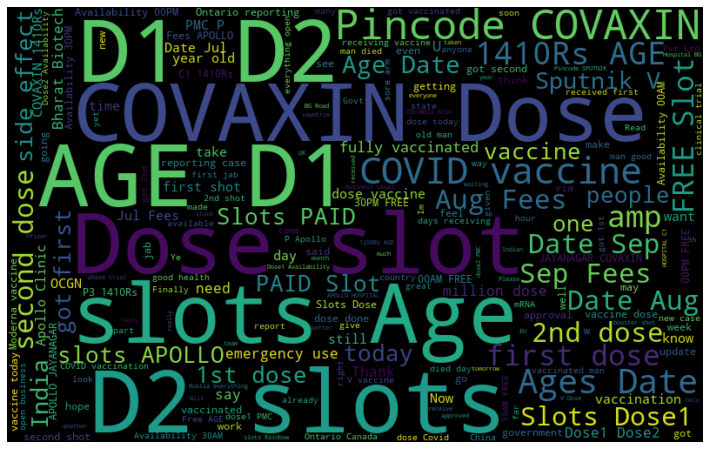

In [8]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in tweets_data['text_nlp']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
# if you want to study more, below link is so useful for me
# https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

sample = tweets_data['text_nlp'][22]
print(sample)

testimonial = TextBlob(sample)
pola = testimonial.sentiment.polarity
subj = testimonial.sentiment.subjectivity
print('pola', pola, 'subj', subj)

Trump announces rollout 'in less 24 hours' The first Americans vaccinated
pola 0.04166666666666667 subj 0.19999999999999998


In [10]:
sample = 'Thank you, but I finally use other items another gave me'
print(sample)

testimonial = TextBlob(sample)
pola = testimonial.sentiment.polarity
subj = testimonial.sentiment.subjectivity
print('pola', pola, 'subj', subj)

Thank you, but I finally use other items another gave me
pola -0.0625 subj 0.6875


In [11]:
def polarity(text):
    testimonial = TextBlob(text)
    polarity = testimonial.sentiment.polarity
    return polarity


def subjectivity(text):
    testimonial = TextBlob(text)
    subjectivity = testimonial.subjectivity
    return subjectivity


def senti(text, polarity_threshold=0.2):
    testimonial = TextBlob(text)
    senti = testimonial.sentiment.polarity
    
    if senti >= polarity_threshold:
        return 'Positive'
    elif np.abs(senti) < polarity_threshold:
        return 'Neutral'
    else:
        return 'Negative'
    

tweets_data['polarity'] = tweets_data['text_nlp'].apply(lambda x: polarity(x))
tweets_data['subjectivity'] = tweets_data['text_nlp'].apply(lambda x: subjectivity(x))
tweets_data['sentiment'] = tweets_data['text_nlp'].apply(lambda x: senti(x))
tweets_data.head()

,id,date,text,hashtags,text_nlp,polarity,subjectivity,sentiment
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cyt...,PfizerBioNTech,Same folks said daikon paste could treat cytok...,0.0,0.125000,Neutral
1,1338158543359250433,2020-12-13,While the world has been on the wrong side of ...,Notags,"While world wrong side history year, hopefully...",-0.5,0.900000,Negative
2,1337858199140118533,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"coronavirus,SputnikV,AstraZeneca,PfizerBioNTec...",Russian vaccine created last 2-4 years,0.0,0.033333,Neutral
3,1337855739918835717,2020-12-12,"Facts are immutable, Senator, even when you're...",Notags,"Facts immutable, Senator, even ethically sturd...",0.1,0.550000,Neutral
4,1337854064604966912,2020-12-12,Explain to me again why we need a vaccine @Bor...,"whereareallthesickpeople,PfizerBioNTech",Explain need vaccine,0.0,0.000000,Neutral


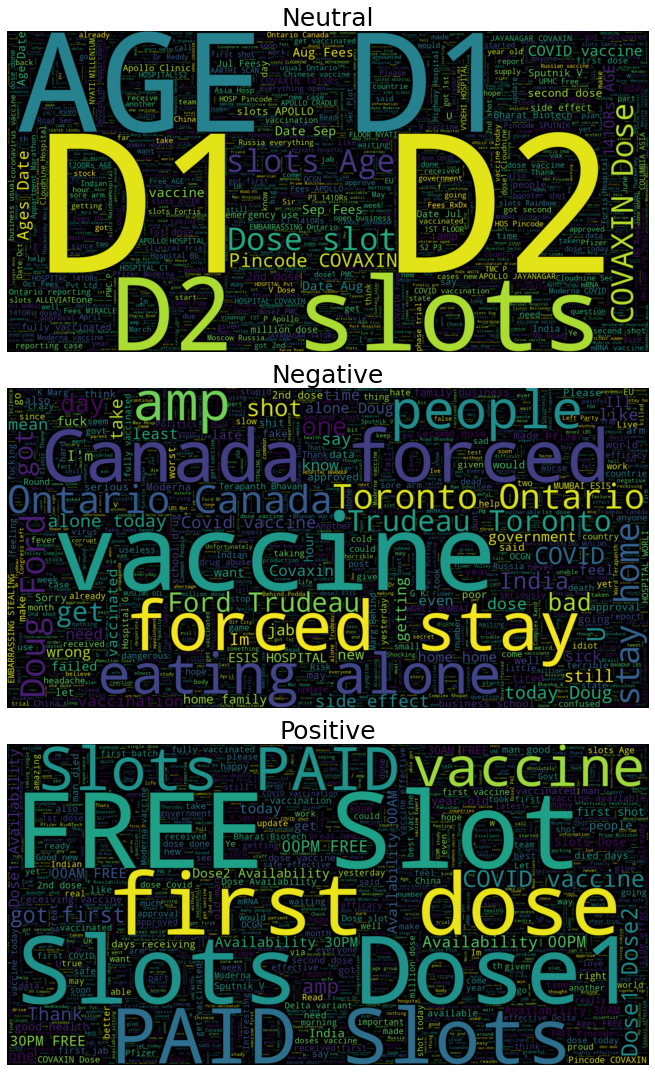

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
sentiments = tweets_data['sentiment'].unique()
for i, senti in enumerate(sentiments):
    senti_df = tweets_data.query('sentiment==@senti')
    cloud = ' '.join([tweet for tweet in senti_df['text_nlp']])
    wc = WordCloud(max_words=2000, width=1600, \
                   height=800, stopwords=stopwords).generate(cloud)

    ax[i].set_title(senti, fontsize=25)
    ax[i].axis('off')
    ax[i].imshow(wc , interpolation = 'bilinear')
    
plt.tight_layout()
plt.show()

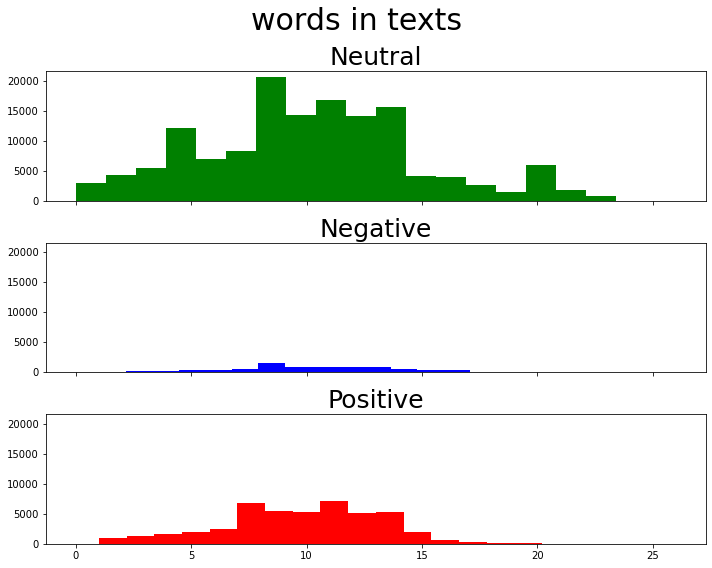

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

sentiments = tweets_data['sentiment'].unique()
colors = ['green', 'blue', 'red']
plt.suptitle('words in texts', fontsize=30)
for i, senti in enumerate(sentiments):
    senti_df = tweets_data.query('sentiment==@senti')
    # number of words in text
    # ex. 'Explain need vaccine' -> 3
    words_len = senti_df['text_nlp'].str.split().map(lambda x: len(x))
    ax[i].set_title(senti, fontsize=25)
    ax[i].hist(words_len, color=colors[i], bins=20)
    
plt.tight_layout()
plt.show()

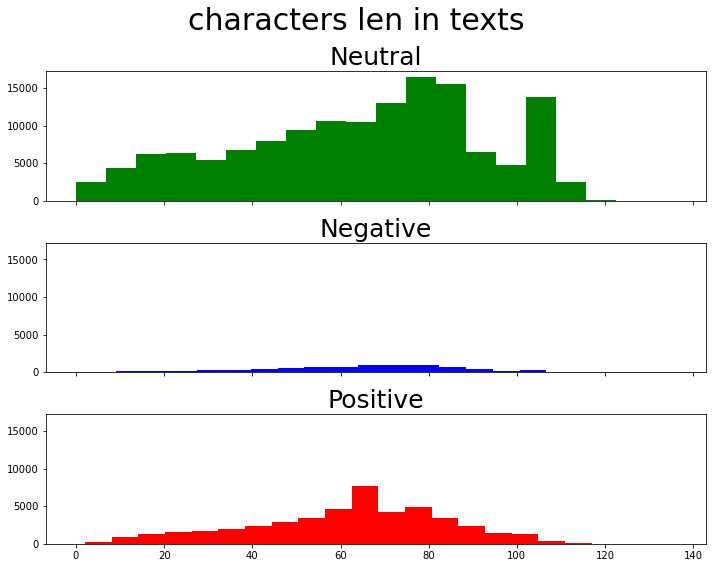

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

sentiments = tweets_data['sentiment'].unique()
plt.suptitle('characters len in texts', fontsize=30)
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    posi_df = tweets_data.query('sentiment==@senti')
    # chars of words in text
    words_len = posi_df['text_nlp'].str.len()
    ax[i].set_title(senti, fontsize=25)
    ax[i].hist(words_len, color=colors[i], bins=20)
    
plt.tight_layout()
plt.show()

C:\Users\himanshu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


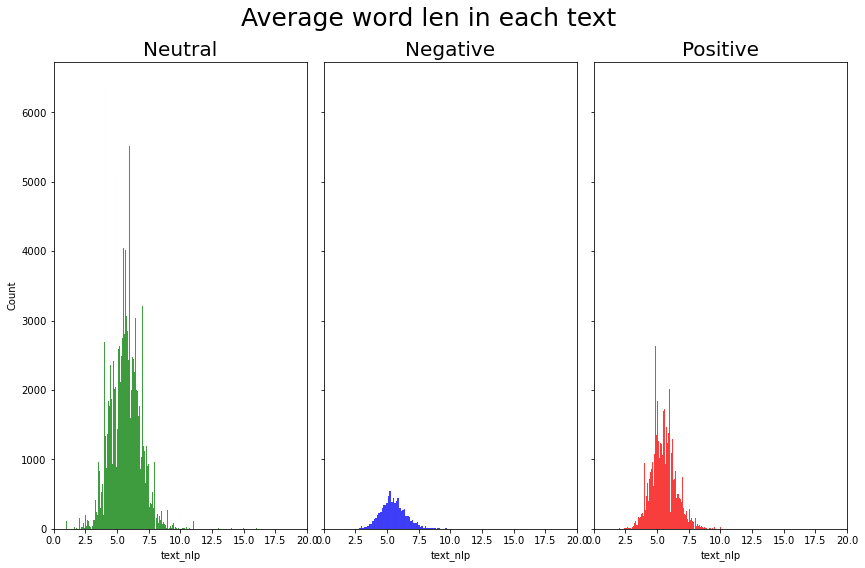

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True, sharex=True)
sentiments = tweets_data['sentiment'].unique()
colors = ['green', 'blue', 'red']
fig.suptitle('Average word len in each text', fontsize=25)

for i, senti in enumerate(sentiments):
    senti_df = tweets_data.query('sentiment==@senti')
    word = senti_df['text_nlp'].str.split().apply(lambda x: [len(i) for i in x])
    sns.histplot(word.apply(lambda x: np.mean(x)), ax=ax[i], color=colors[i])
    ax[i].set_title(senti, fontsize=20)

plt.tight_layout()
plt.xlim([0, 20])
plt.show()

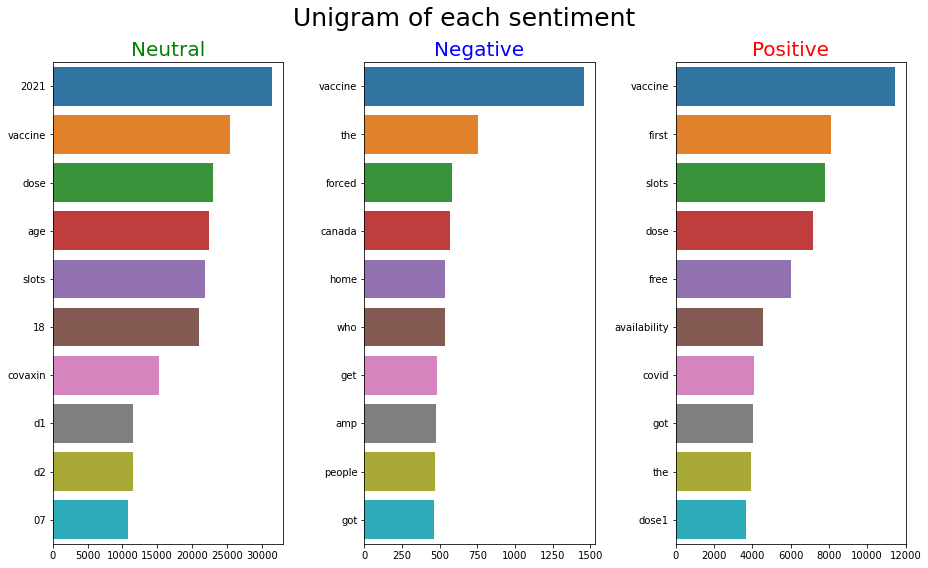

In [16]:
# via https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, ax = plt.subplots(1, 3, figsize=(13,8))
sentiments = tweets_data['sentiment'].unique()
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    senti_df = senti_df = tweets_data.query('sentiment==@senti')['text_nlp']
    most_common_bi = get_top_text_ngrams(senti_df,10,1)
    most_common_bi = dict(most_common_bi)
    sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()), ax=ax[i])
    ax[i].set_title(senti, fontsize=20, color=colors[i])

plt.suptitle('Unigram of each sentiment', fontsize=25)
plt.tight_layout()
plt.show()

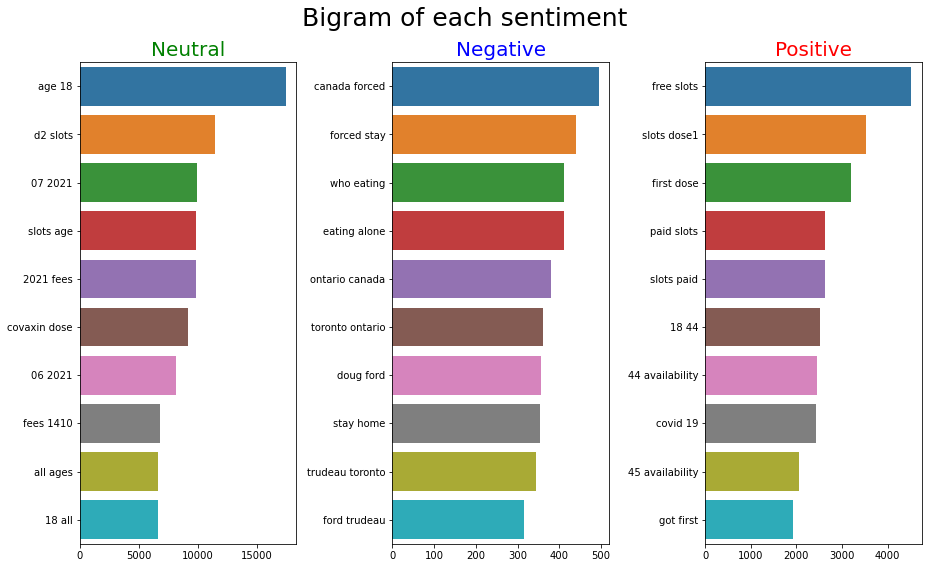

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(13,8))
sentiments = tweets_data['sentiment'].unique()
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    senti_df = senti_df = tweets_data.query('sentiment==@senti')['text_nlp']
    most_common_bi = get_top_text_ngrams(senti_df, 10, 2)
    most_common_bi = dict(most_common_bi)
    sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()), ax=ax[i])
    ax[i].set_title(senti, fontsize=20, color=colors[i])

plt.suptitle('Bigram of each sentiment', fontsize=25)
plt.tight_layout()
plt.show()

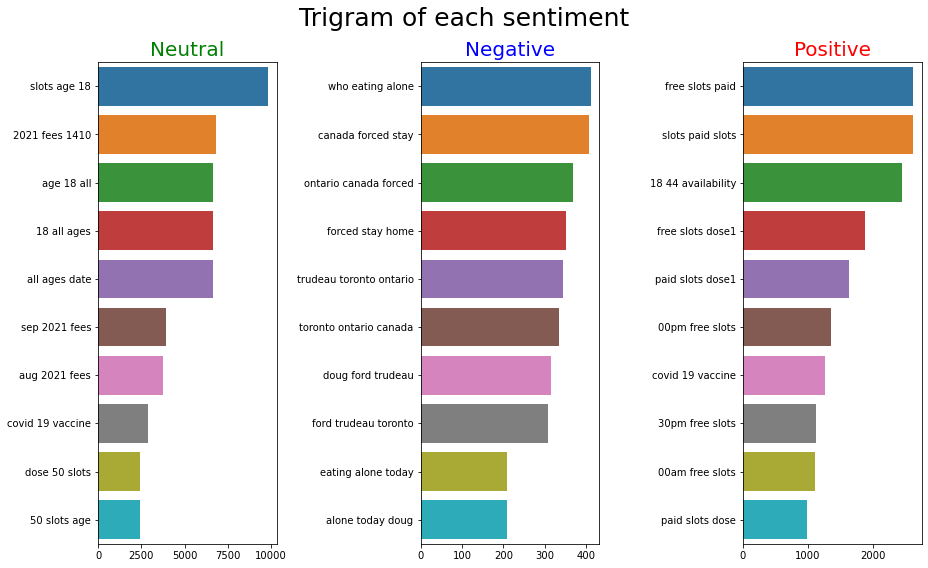

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(13,8))
sentiments = tweets_data['sentiment'].unique()
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    senti_df = senti_df = tweets_data.query('sentiment==@senti')['text_nlp']
    most_common_bi = get_top_text_ngrams(senti_df, 10, 3)
    most_common_bi = dict(most_common_bi)
    sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()), ax=ax[i])
    ax[i].set_title(senti, fontsize=20, color=colors[i])

plt.suptitle('Trigram of each sentiment', fontsize=25)
plt.tight_layout()
plt.show()

In [19]:
hashtags = tweets_data['hashtags']
head_refs = ['pfize', 'biont', 'sinop', 'sinov', 'moder', 'oxfor', 'astra', 'covax', 'sputn']
reference_dict = {'pfize': 'Pfizer/BioNTech', 
                  'biont': 'Pfizer/BioNTech', 
                  'sinop': 'Sinopharm', 
                  'sinov': 'Sinovac', 
                  'moder': 'Moderna', 
                  'oxfor': 'Oxford/AstraZeneca', 
                  'astra': 'Oxford/AstraZeneca', 
                  'covax': 'Covaxin', 
                  'sputn': 'Sputnik V'}

kinds_of_refs = []
for hashtag in hashtags:
    tag_list = []
    tags = hashtag.split(',')
    for tag in tags:
        if tag.lower()[:5] in reference_dict.keys():
            refer = reference_dict[tag.lower()[:5]]
            tag_list.append(refer)
    
    if len(tag_list) > 0:
        kinds_of_refs.append(tag_list)
    else:
        kinds_of_refs.append(['NoTags'])
            
tweets_data['vaccine_hashtags'] = kinds_of_refs

In [20]:
def reference(tags, refs):
    flag = 0
    if refs in tags:
        return 1
    else:
        return 0
    
tweets_data['pfizer'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Pfizer/BioNTech'))
tweets_data['sinopharm'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Sinopharm'))
tweets_data['sinovac'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Sinovac'))
tweets_data['moderna'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Moderna'))
tweets_data['oxford'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Oxford/AstraZeneca'))
tweets_data['covaxin'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Covaxin'))
tweets_data['sputnik'] = tweets_data['vaccine_hashtags'].apply(lambda x: reference(x, 'Sputnik V'))


In [21]:
tweets_data = tweets_data.drop(['hashtags', 'vaccine_hashtags'], axis=1)
tweets_data.head(3)

,id,date,text,text_nlp,polarity,subjectivity,sentiment,pfizer,sinopharm,sinovac,moderna,oxford,covaxin,sputnik
0,1340539111971516416,2020-12-20,Same folks said daikon paste could treat a cyt...,Same folks said daikon paste could treat cytok...,0.0,0.125000,Neutral,1,0,0,0,0,0,0
1,1338158543359250433,2020-12-13,While the world has been on the wrong side of ...,"While world wrong side history year, hopefully...",-0.5,0.900000,Negative,0,0,0,0,0,0,0
2,1337858199140118533,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,Russian vaccine created last 2-4 years,0.0,0.033333,Neutral,1,0,0,1,1,0,1


In [22]:
results = {}
vaccines = ['pfizer', 'sinopharm', 'sinovac', 'moderna', 'oxford', 'covaxin', 'sputnik']
for vaccine in vaccines:
    prefix = vaccine + '_'
    df = pd.DataFrame(tweets_data.query(f'{vaccine}==1')[['polarity', 'subjectivity']].describe())
    results[prefix] = df
    
stats_dict = pd.concat(results.values(), axis=1, keys=results.keys())
stats_dict

pfizer_                 sinopharm_                  sinovac_  \
           polarity  subjectivity     polarity subjectivity     polarity   
count  17189.000000  17189.000000  7862.000000  7862.000000  9693.000000   
mean       0.091951      0.250202     0.140201     0.251644     0.082718   
std        0.239372      0.302407     0.276618     0.294550     0.216027   
min       -1.000000      0.000000    -1.000000     0.000000    -1.000000   
25%        0.000000      0.000000     0.000000     0.000000     0.000000   
50%        0.000000      0.066667     0.000000     0.100000     0.000000   
75%        0.187500      0.475000     0.250000     0.500000     0.148182   
max        1.000000      1.000000     1.000000     1.000000     1.000000   

                        moderna_                    oxford_               \
      subjectivity      polarity  subjectivity     polarity subjectivity   
count  9693.000000  37506.000000  37506.000000  6700.000000  6700.000000   
mean      0.207482      0.088649      0.248872     0.087890     0.254129   
std       0.280764      0.235499      0.293280     0.249782     0.312219   
min       0.000000     -1.000000      0.000000    -1.000000     0.000000   
25%       0.000000      0.000000      0.000000     0.000000     0.000000   
50%       0.000000      0.000000      0.111111     0.000000     0.033333   
75%       0.350000      0.195312      0.454545     0.175000     0.500000   
max       1.000000      1.000000      1.000000     1.000000     1.000000   

           covaxin_                    sputnik_                
           polarity  subjectivity      polarity  subjectivity  
count  49244.000000  49244.000000  13960.000000  13960.000000  
mean       0.068183      0.171136      0.084038      0.214072  
std        0.207097      0.277242      0.220612      0.286650  
min       -1.000000      0.000000     -1.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.333333      0.136364      0.400000  
max        1.000000      1.000000      1.000000      1.000000

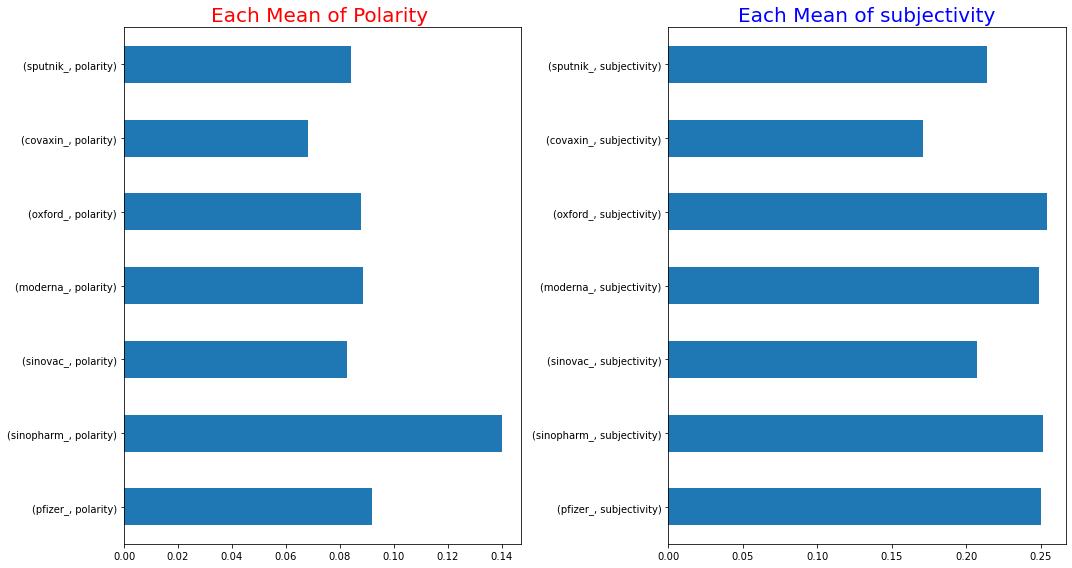

In [23]:
_, axes = plt.subplots(1, 2, figsize=(15, 8))
stats_dict.loc['mean', ::2].plot(kind='barh', ax=axes[0])
stats_dict.iloc[1, 1::2].plot(kind='barh', ax=axes[1])
axes[0].set_title('Each Mean of Polarity ', fontsize=20, color='red')
axes[1].set_title('Each Mean of subjectivity', fontsize=20, color='blue')

plt.tight_layout()
plt.show()

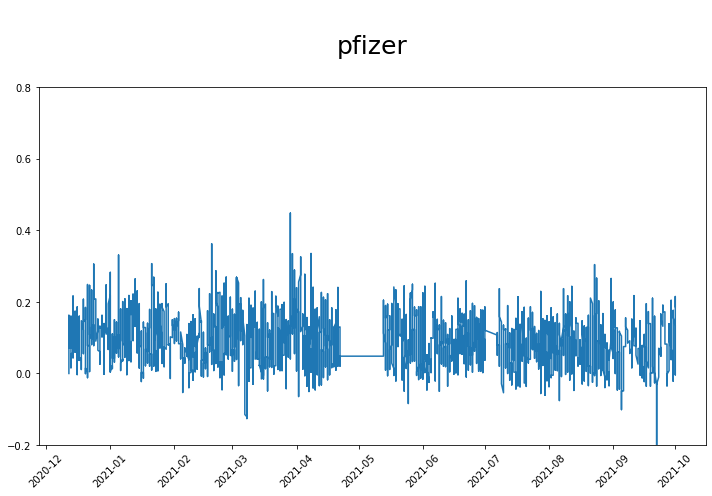

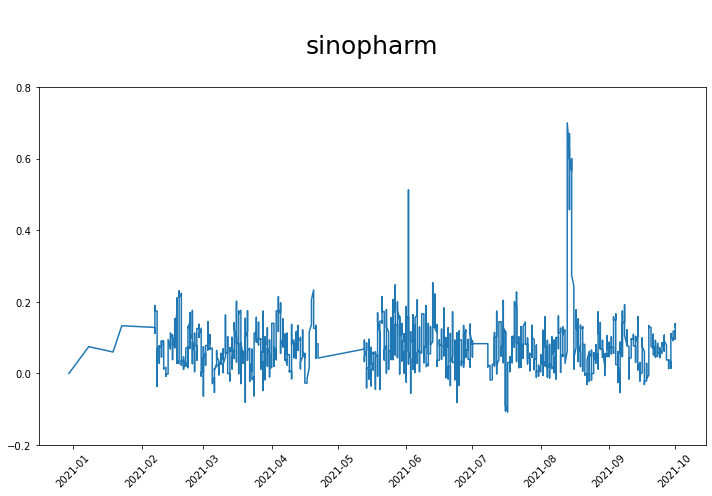

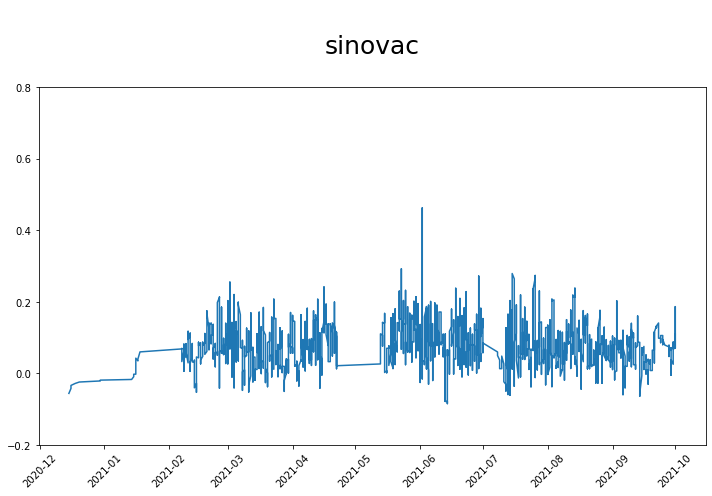

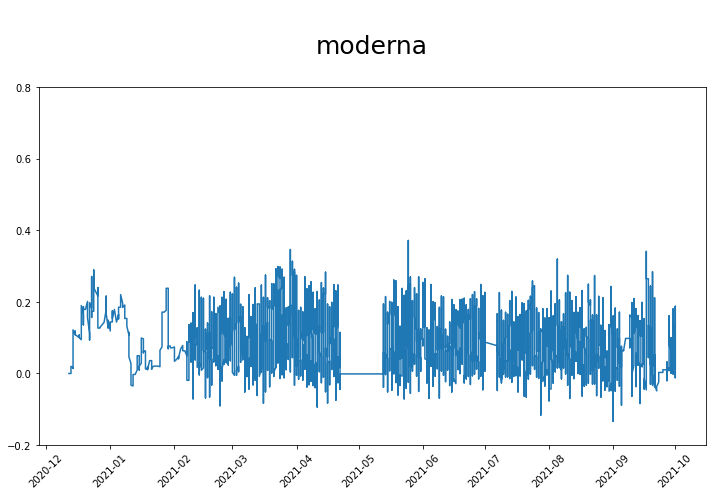

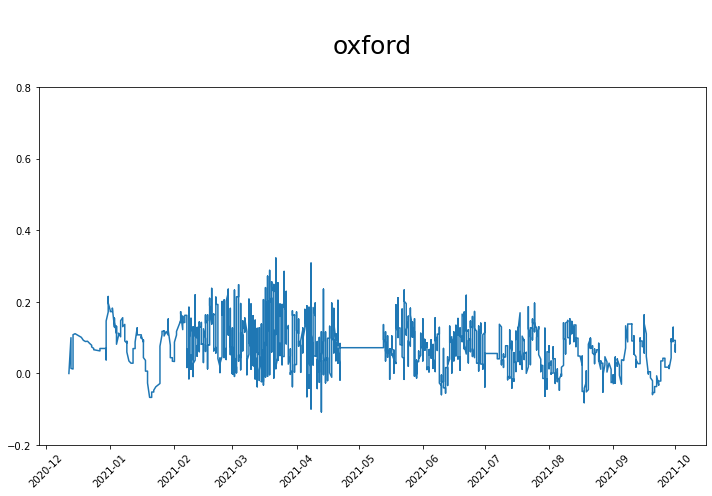

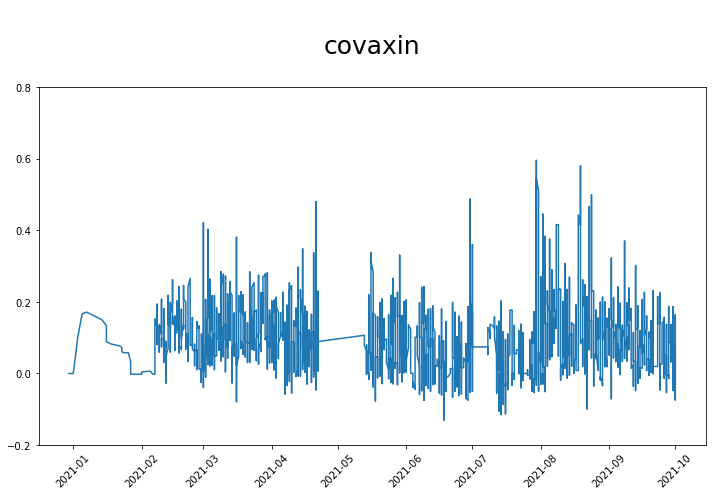

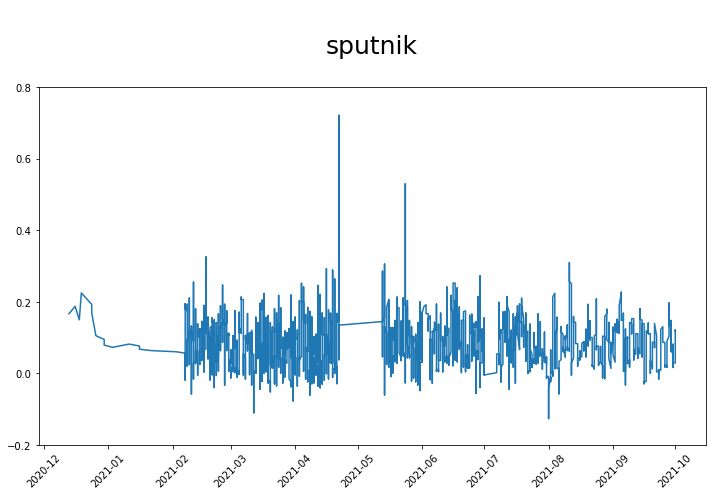

In [24]:
vaccines_df = {}

for vaccine in vaccines:
    df = tweets_data.query(f'{vaccine}==1')[['date', 'polarity', 'sentiment']]
    df = df.sort_values(by='date')
    df['Avg_'+vaccine] = df.polarity.rolling(20, min_periods=3).mean()
    vaccines_df[vaccine] = df

for i, (name, df) in enumerate(vaccines_df.items()):
    plt.figure(figsize=(10, 7))
    plt.plot(df.date, df.iloc[:, -1])
    plt.xticks(rotation=45)
    plt.title('\n'+name+'\n', fontsize=25)
    plt.ylim([-0.2, 0.8])
    plt.tight_layout()
    plt.show()

Sinop, covax, sput have the mountain in above graph, this means those vaccine have good sentiment in Twitter at that time!